# Set-up

In [1]:
import os
import numpy as np
import eugene as eu

Global seed set to 13


GPU is available: True
Number of GPUs: 1
Current GPU: 0
GPUs: Quadro RTX 5000


In [2]:
print(eu.settings.gpus)
eu.settings.dataset_dir = "/cellar/users/aklie/data/eugene"

1


# Load and preprocess dataset

## From `SeqData`

In [3]:
sdata_train = eu.datasets.deAlmeida22("train")
eu.pp.ohe_seqs_sdata(sdata_train)
sdataset_train = sdata_train.to_dataset(target_vars=['Dev_log2_enrichment_quantile_normalized', 'Hk_log2_enrichment_quantile_normalized'])
sdataloader_train = sdataset_train.to_dataloader(batch_size=100, shuffle=True, num_workers=4)

Dataset deAlmeida22 Sequences_Train.fa has already been downloaded.
Dataset deAlmeida22 Sequences_activity_Train.txt has already been downloaded.



SeqData object modified:
	ohe_seqs: None -> 402296 ohe_seqs added
No transforms given, assuming just need to tensorize.


In [46]:
sdataloader_train = sdataset_train.to_dataloader(batch_size=128, shuffle=True, num_workers=2)

In [18]:
sdata_val = eu.datasets.deAlmeida22("val")
eu.pp.ohe_seqs_sdata(sdata_val)
sdataset_val = sdata_val.to_dataset(target_vars=['Dev_log2_enrichment_quantile_normalized', 'Hk_log2_enrichment_quantile_normalized'])
sdataloader_val = sdataset_val.to_dataloader(batch_size=128, shuffle=False, num_workers=16)

Dataset deAlmeida22 Sequences_Val.fa has already been downloaded.
Dataset deAlmeida22 Sequences_activity_Val.txt has already been downloaded.


One-hot encoding sequences:   0%|          | 0/40570 [00:00<?, ?it/s]

SeqData object modified:
	ohe_seqs: None -> 40570 ohe_seqs added
No transforms given, assuming just need to tensorize.


In [47]:
sdataloader_val = sdataset_val.to_dataloader(batch_size=128, shuffle=False, num_workers=2)

In [19]:
len(sdataloader_train), len(sdataloader_val)

(4023, 406)

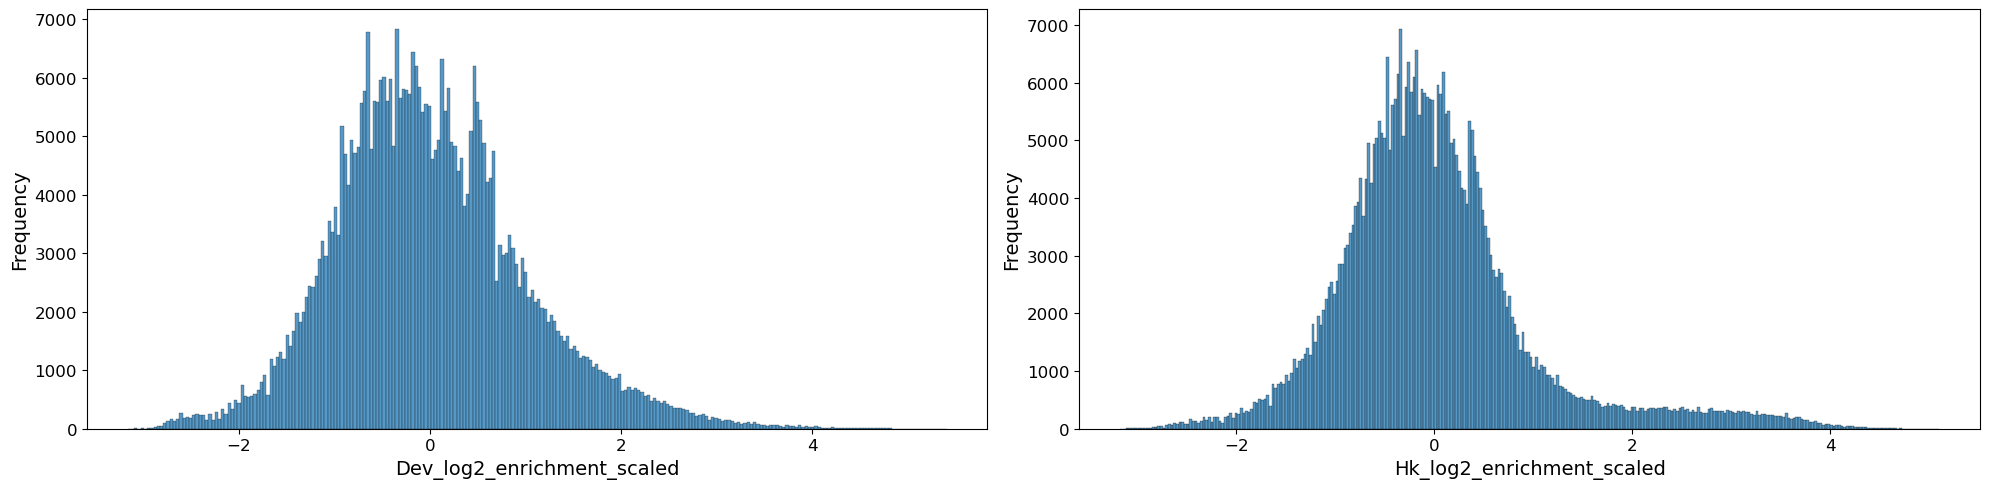

In [20]:
eu.pl.histplot(
    sdata_train,
    vars=['Dev_log2_enrichment_scaled', 'Hk_log2_enrichment_scaled'],
    orient="h"
)

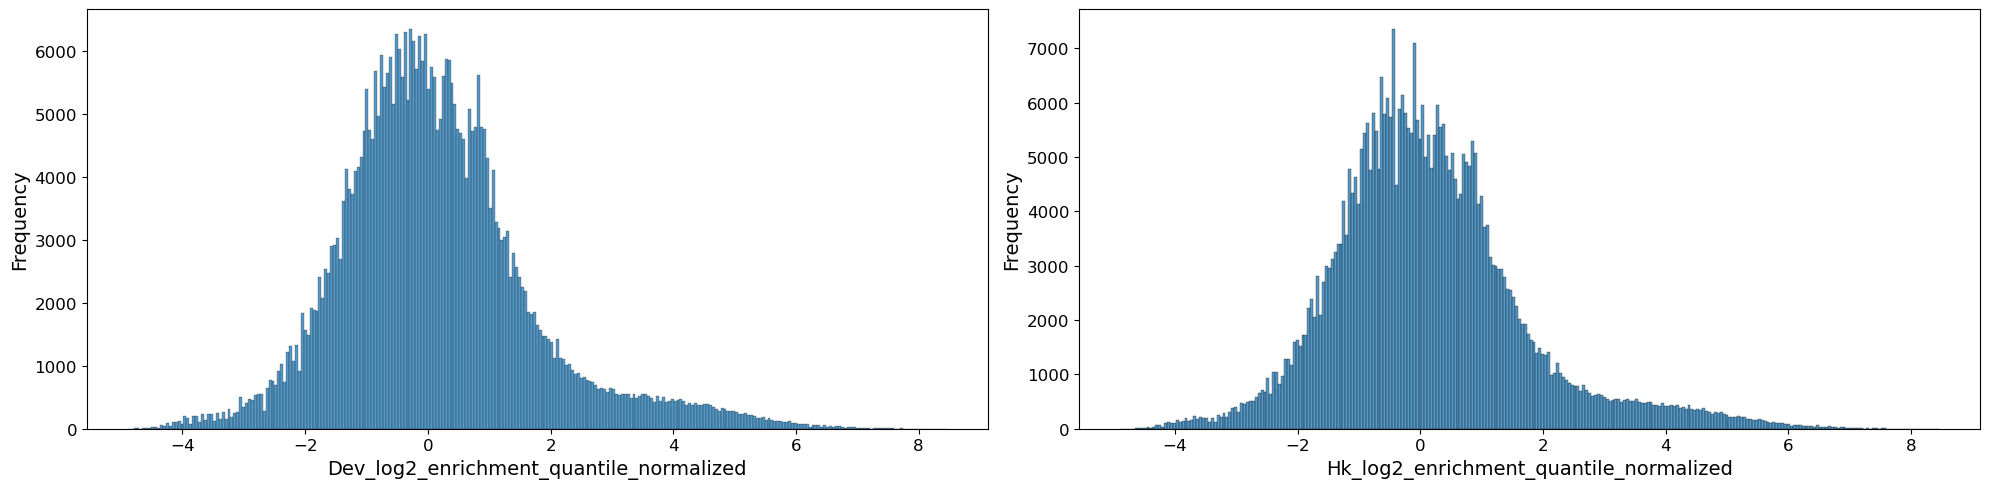

In [21]:
eu.pl.histplot(
    sdata_train,
    vars=['Dev_log2_enrichment_quantile_normalized', 'Hk_log2_enrichment_quantile_normalized'],
    orient="h"
)

## From `h5py`

In [8]:
from eugene.dataload.datamodules._H5DataModule import H5DataModule

In [9]:
%%bash
cd /cellar/users/aklie/data/eugene/deAlmeida22
wget https://zenodo.org/record/7265991/files/DeepSTARR_data.h5

--2022-12-19 13:41:40--  https://zenodo.org/record/7265991/files/DeepSTARR_data.h5
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 294581428 (281M) [application/octet-stream]
Saving to: ‘DeepSTARR_data.h5’

     0K .......... .......... .......... .......... ..........  0%  313K 15m19s
    50K .......... .......... .......... .......... ..........  0%  314K 15m18s
   100K .......... .......... .......... .......... ..........  0% 64.9M 10m13s
   150K .......... .......... .......... .......... ..........  0% 85.2M 7m41s
   200K .......... .......... .......... .......... ..........  0%  314K 9m11s
   250K .......... .......... .......... .......... ..........  0% 94.9M 7m40s
   300K .......... .......... .......... .......... ..........  0% 91.7M 6m35s
   350K .......... .......... .......... .......... ..........  0% 83.6M 5m46s
   400K .......... ........

In [14]:
filepath = os.path.join(eu.settings.dataset_dir, "deAlmeida22", "DeepSTARR_data.h5")
data_module = H5DataModule(filepath, batch_size=100, lower_case=False, transpose=False)

In [15]:
data_module

# Instantiate model

## From `EUGENe`

In [43]:
from eugene.models import DeepSTARR

In [48]:
model = DeepSTARR(
    input_len=249, 
    output_dim=2, 
    optimizer_lr=0.002,
    optimizer_kwargs=dict(weight_decay=1e-6)
)
eu.models.init_weights(model)

In [49]:
model

DeepSTARR(
  (train_metric): R2Score()
  (val_metric): R2Score()
  (test_metric): R2Score()
  (conv1d_tower): Conv1DTower(
    (layers): Sequential(
      (0): Conv1d(4, 246, kernel_size=(7,), stride=(1,), padding=same)
      (1): BatchNorm1d(246, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
      (4): Conv1d(246, 60, kernel_size=(3,), stride=(1,), padding=same)
      (5): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
      (8): Conv1d(60, 60, kernel_size=(5,), stride=(1,), padding=same)
      (9): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
      (11): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
      (12): Conv1d(60, 120, kernel_size=(3,), str

## Other instantiation methods

# Train model

## With `EUGENe`

In [19]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
# Try to instantiate it
%tensorboard --logdir eugene_logs

In [50]:
eu.train.fit(
    model,
    train_dataloader=sdataloader_train,
    val_dataloader=sdataloader_val,
    gpus=1,
    epochs=100,
    early_stopping_callback=True,
    early_stopping_patience=10,
)

Global seed set to 13
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name         | Type        | Params
---------------------------------------------
0 | train_metric | R2Score     | 0     
1 | val_metric   | R2Score     | 0     
2 | test_metric  | R2Score     | 0     
3 | conv1d_tower | Conv1DTower | 92.2 K
4 | dense_block  | DenseBlock  | 7.6 M 
---------------------------------------------
7.7 M     Trainable params
0         Non-trainable params
7.7 M     Total params
30.745    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
Global seed set to 13
/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

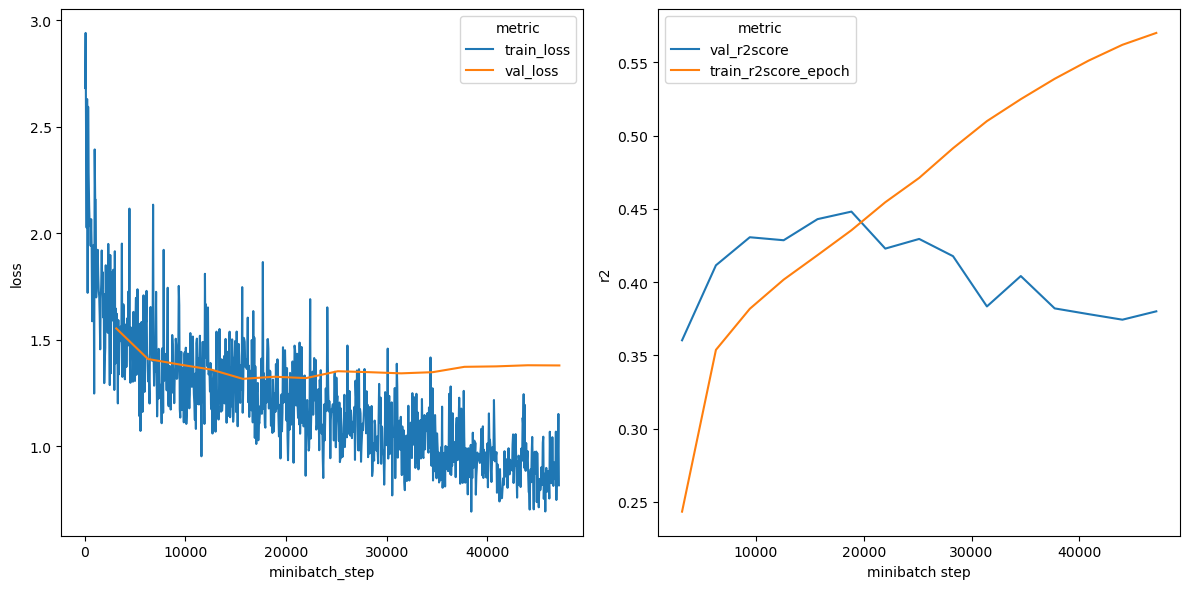

In [52]:
eu.pl.training_summary("eugene_logs/ssDeepSTARR_regression/version_3/")

# Evaluation

In [61]:
MODEL_PATH = "/cellar/users/aklie/projects/EUGENe_use_cases/deAlmeida22/eugene_logs/ssDeepSTARR_regression/version_0/checkpoints/epoch=4-step=15714.ckpt"

In [63]:
best_model = eu.models.DeepSTARR.load_from_checkpoint(MODEL_PATH)

In [71]:
sdata_test = eu.datasets.deAlmeida22("test")
eu.pp.ohe_seqs_sdata(sdata_test)

Dataset deAlmeida22 Sequences_Test.fa has already been downloaded.
Dataset deAlmeida22 Sequences_activity_Test.txt has already been downloaded.


One-hot encoding sequences:   0%|          | 0/41186 [00:00<?, ?it/s]

SeqData object modified:
	ohe_seqs: None -> 41186 ohe_seqs added


In [72]:
eu.evaluate.predictions(
    best_model,
    sdata_test,
    target_vars=['Dev_log2_enrichment_scaled', 'Hk_log2_enrichment_scaled'],
    file_label="test"
)

No transforms given, assuming just need to tensorize.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + Dev_log2_enrichment_scaled_predictions, Hk_log2_enrichment_scaled_predictions


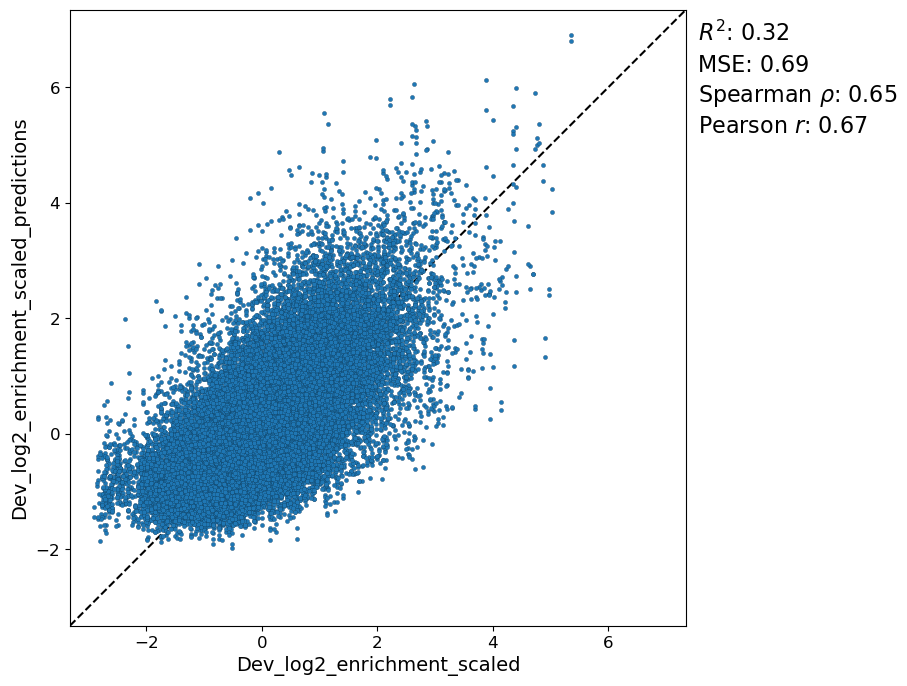

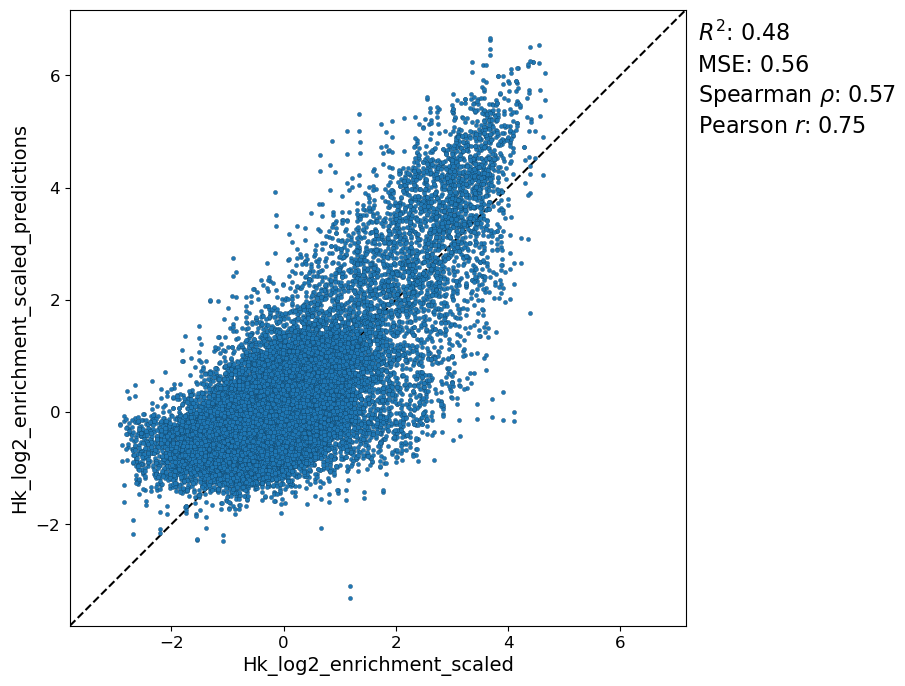

In [87]:
eu.pl.performance_scatter(
    sdata_test,
    target_vars=['Dev_log2_enrichment_scaled', 'Hk_log2_enrichment_scaled'],
    prediction_vars=['Dev_log2_enrichment_scaled_predictions', 'Hk_log2_enrichment_scaled_predictions']
)

## Kipoi model

In [89]:
eu.external.kipoi.get_model_names("DeepSTARR")

Already up to date.


91    DeepSTARR
Name: model, dtype: object

In [90]:
kipoi_model = eu.external.kipoi.get_model("DeepSTARR")

Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepSTARR/downloaded/model_files/arch/9b796f79441e53dc75dd79b911fff872
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepSTARR/downloaded/model_files/weights/7e53a9351b2520a4713a5ffdb5f1566c


2022-12-19 16:28:27.024160: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-19 16:28:27.479544: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepSTARR/downloaded/model_files/weights/7e53a9351b2520a4713a5ffdb5f1566c: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


In [92]:
kipoi_preds = kipoi_model(sdata_test.ohe_seqs.transpose(0,2,1))

In [102]:
sdata_test.seqs_annot[['Dev_kipoi_predictions', 'Hk_kipoi_predictions']] = np.hstack(kipoi_preds)

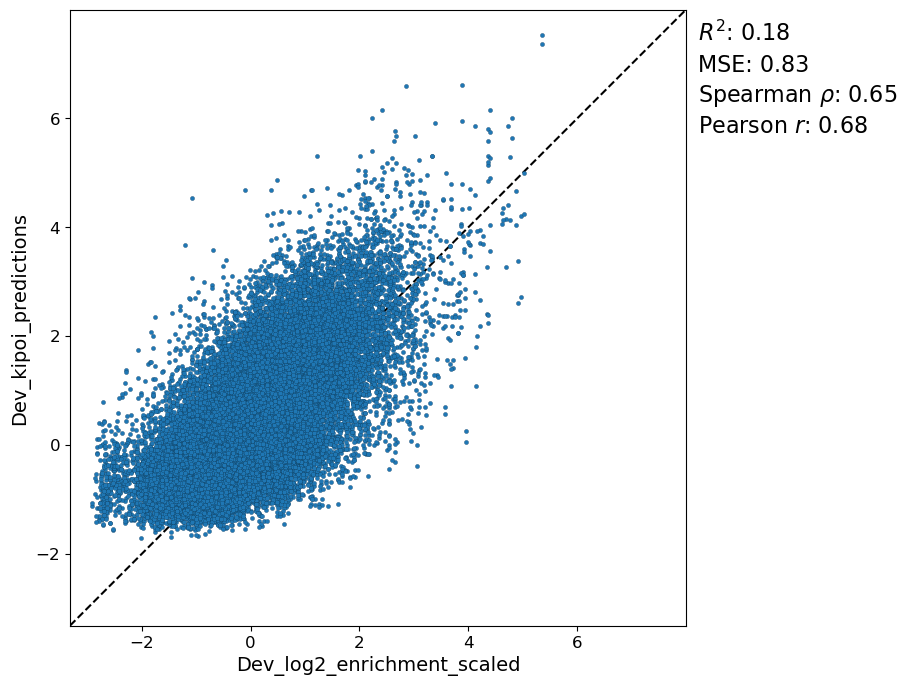

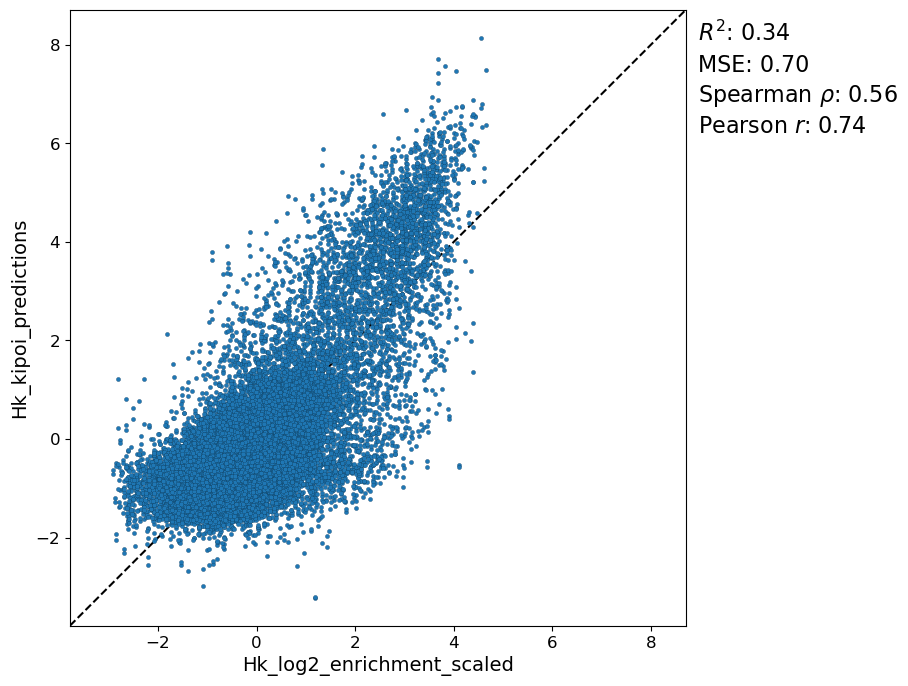

In [103]:
eu.pl.performance_scatter(
    sdata_test,
    target_vars=['Dev_log2_enrichment_scaled', 'Hk_log2_enrichment_scaled'],
    prediction_vars=['Dev_kipoi_predictions', 'Hk_kipoi_predictions']
)

---

# Scratch